In [ ]:
@todo
# Get analyses to Flask

@in_progress
# Refactoring for supporting analysis of any new IA (from txt file)

@done
# Added function to get path length
# Added wrappers to integrate path length to original test set function
# Add 2 way transition btw outline, nested dico and D3 format

@later 
# Add target feature selector in IA outline?
# Add path familiarity and similarity?

# Testing infoscent with slightly more complex IA 
# (all terminals > level 2)

This notebook explores the robustness of the analysis to IA complexification. Outcome seems positive!

In [25]:
import pickle, operator, json, requests

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Natural Language Processing modules
from gensim import corpora, models, similarities, utils
from pattern.en import tag, parse
from nltk.corpus import wordnet as wn, stopwords
from nltk.tokenize import RegexpTokenizer

# Data/Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics and Machine-learning modules
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import datasets, linear_model

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 1. Materials

### GUI IAs

The GUI for this project follows the IA of an on-board computer.

In [2]:
# GUI information architectures (IAs) represented as a nested dictionary

gui4 = {"car":{"air conditioning" : {"increase celsius degrees": "increase celsius degrees","ventilation settings": "ventilation settings", 
                  "recycling mode":"recycling mode"},
               "driving assistance" : {"gps": "gps", 
                                       "lane change alert" : "lane change alert", 
                                      "cruise control": {"activate cruise control":"activate cruise control", 
                                                         "turn off cruise control":"turn off cruise control"}, 
                                      "anti theft notification" :"anti theft notification"}}, 
        "phone": {"dial": "dial","contact list": "contact list", 
                  "check voice mail messages":"check voice mail messages"}, 
        "entertainment": {"play radio": "play radio","television": "television", 
                  "gaming":"gaming"}}

**User-friendly representations:**
- D3 dendrogram 
- indented outline

In [3]:
# This function generates IA description and syntax for drawing D3 dendrograms

print 'gui = { "name": "home", "children":['
def nested2d3(dico, indent = '   '):
    for k in dico.keys():
        print indent + '{ "name": "' + str(k) + '",'
        if isinstance(dico[k], dict):
            print indent + '"children":['
            nested2d3(dico[k], indent + "   ")
        if isinstance(dico[k], str):
            print indent + ' "size": 20},'
    print ']},'

nested2d3(gui4)

# For now, must copy/paste output to flask_gui.py and launch server to get:
# Will do a little thingie using boostrap @later

gui = { "name": "home", "children":[
   { "name": "car",
   "children":[
      { "name": "air conditioning",
      "children":[
         { "name": "ventilation settings",
          "size": 20},
         { "name": "recycling mode",
          "size": 20},
         { "name": "increase celsius degrees",
          "size": 20},
]},
      { "name": "driving assistance",
      "children":[
         { "name": "cruise control",
         "children":[
            { "name": "activate cruise control",
             "size": 20},
            { "name": "turn off cruise control",
             "size": 20},
]},
         { "name": "anti theft notification",
          "size": 20},
         { "name": "lane change alert",
          "size": 20},
         { "name": "gps",
          "size": 20},
]},
]},
   { "name": "entertainment",
   "children":[
      { "name": "gaming",
       "size": 20},
      { "name": "television",
       "size": 20},
      { "name": "play radio",
       "size": 20},
]},
   { "name": "pho

<img src="files/D3_gui4.png" width=400 />

In [36]:
# This function translates a nested dictionary in intended outline

def recurse_dico_keys(dico, indent = '   '):
    for k in dico.keys():
        print indent+str(k)
        if isinstance(dico[k], dict):
            recurse_dico_keys(dico[k], indent + '   ')
            
recurse_dico_keys(gui4)

   car
      air conditioning
         ventilation settings
         recycling mode
         increase celsius degrees
      driving assistance
         cruise control
            activate cruise control
            turn off cruise control
         anti theft notification
         lane change alert
         gps
   entertainment
      gaming
      television
      play radio
   phone
      contact list
      dial
      check voice mail messages


###  Target features, goal descriptions, and their respective familiarity/technicality 

Preparing a test_set that list all the target feature or an IA, plus slots for variables of interest and test specifications

In [37]:
# Function for listing any IA's target features + slots for corresponding goal descriptions and technicality

def list_gui_target_features(gui, f_list=[], g_list=[], t_list=[]):
    for k in gui.keys():
        if type(gui[k]) is str:
            f_list.append(gui[k])
            g_list.append('')
            t_list.append('')
        else:
            list_gui_target_features(gui[k])                           
    return zip (f_list, g_list, t_list)

list_gui_target_features(gui4)

[('ventilation settings', '', ''),
 ('recycling mode', '', ''),
 ('increase celsius degrees', '', ''),
 ('activate cruise control', '', ''),
 ('turn off cruise control', '', ''),
 ('anti theft notification', '', ''),
 ('lane change alert', '', ''),
 ('gps', '', ''),
 ('gaming', '', ''),
 ('television', '', ''),
 ('play radio', '', ''),
 ('contact list', '', ''),
 ('dial', '', ''),
 ('check voice mail messages', '', '')]

In [38]:
# Function for determining path lengths (= prescribed number of steps to target feature)
f_list = []
def steps_to_targ_feat (gui, glob , c_list = []):   
    for v in gui.values():   
        if type(v) is dict:
            steps_to_targ_feat(v, glob + 1)
        else:
            f_list.append(v)
            c_list.append(glob)     
    return c_list #, f_list

steps_to_targ_feat(gui4, 1)

[3, 3, 3, 4, 4, 3, 3, 3, 2, 2, 2, 2, 2, 2]

**Wraping the 2 above functions:**

In [40]:
def wraper1 (gui):
    
    def list_gui_target_features(gui, f_list=[], g_list=[], t_list=[]):
        for k in gui.keys():
            if type(gui[k]) is str:
                f_list.append(gui[k])
                g_list.append('')
                t_list.append('')
            else:
                list_gui_target_features(gui[k])                           
        return zip (f_list, g_list, t_list)
    
    return list_gui_target_features (gui)

In [42]:
def wraper2 (gui, glob): 
    
    def steps_to_targ_feat (gui, glob , c_list = []):   
        for v in gui.values():   
            if type(v) is dict:
                steps_to_targ_feat(v, glob + 1)
            else:
                f_list.append(v)
                c_list.append(glob)     
        return c_list #, f_list

    return steps_to_targ_feat(gui, glob)

#steps_to_targ_feat(gui4, 1)

In [43]:
def test_set(gui):
    l1 = wraper1 (gui)
    l2 = wraper2 (gui, 1)
    l3 = []
    for i, elem in enumerate(l1):
        temp = []
        for n in elem:
            temp.append(n)
        temp.append(l2[i])
        l3.append(tuple(temp))
    return l3
    
test_set_inter = test_set(gui4)
for t in test_set_inter:
    print t

('ventilation settings', '', '', 3)
('recycling mode', '', '', 3)
('increase celsius degrees', '', '', 3)
('activate cruise control', '', '', 4)
('turn off cruise control', '', '', 4)
('anti theft notification', '', '', 3)
('lane change alert', '', '', 3)
('gps', '', '', 3)
('gaming', '', '', 2)
('television', '', '', 2)
('play radio', '', '', 2)
('contact list', '', '', 2)
('dial', '', '', 2)
('check voice mail messages', '', '', 2)


After running the above function, **practitioner must specify goal descriptions and technicality level for each target feature s/he wants to test.**

***test_set representated as a tuple ('target feature', 'goal description', 'technicality')***

In [20]:
test_set1 = [('ventilation settings', 'change fan speed', 'basic'),
 ('increase celsius degrees', 'increase temperature', 'basic'),
 ('recycling mode', 'prevent exterior air enter', 'technical'),
 ('activate cruise control', 'control my speed', 'technical'),
 ('turn off cruise control', 'disable speed alert', 'technical'),
 ('anti theft notification', 'alert that my car stolen', 'technical'),
 ('lane change alert', 'disable car passing support system', 'technical'),
 ('gps', 'get itinerary parc', 'basic'),
 ('gaming', 'play cards', 'basic'),
 ('play radio', 'lookup classical music broadcast', 'basic'),
 ('television', 'watch favorite tv show', 'basic'),
 ('contact list', 'retrieve my friend mailing address', 'basic'),
 ('dial', 'call number', 'basic'),
 ('check voice mail messages', 'listen recent phone messages', 'basic')]

**Wordnet familiarity as an alternative to subjective technicality labelling:**

In [21]:
#Retrieve basic polysemy proxy from nltk's interface for wordnet

wn_fam = []

for test in test_set1:
    tokenizer = RegexpTokenizer(r'\w+')
    toketxt = tokenizer.tokenize(test[1])
    s = set(stopwords.words('english'))
    filt_wrd = [w for w in toketxt if not w in s]
    w_count = len(filt_wrd)
    g_polys = 0

    for word in filt_wrd:
        w_polys = len(wn.synsets(word))
        g_polys += w_polys

    av_polys = float(g_polys)/float(w_count)
    wn_fam.append(round(av_polys, 2))

print sorted(wn_fam)

[3.75, 4.25, 4.5, 5.0, 6.33, 7.25, 7.75, 9.0, 12.33, 13.33, 14.5, 15.0, 29.0, 33.0]


In [23]:
wn_fam_NN = []

for test in test_set1: 
    filt_wrd = []
    g = test[1]
    for w, pos in tag(g): 
        if pos == "NN":
            filt_wrd.append(w)
    #print filt_wrd

    w_count = len(filt_wrd)
    g_polys = 0

    for word in filt_wrd:
        w_polys = len(wn.synsets(word))
        g_polys += w_polys
        
    av_polys = float(g_polys)/float(w_count)
    wn_fam_NN.append(round(av_polys, 2))

print sorted(wn_fam_NN) 

[1.5, 3.67, 4.0, 4.5, 5.0, 9.0, 10.0, 10.0, 10.33, 12.0, 12.33, 18.25, 29.0, 52.0]


['target_feat' 'goal' 'counts' 'familiarity' 'wn_familiarity'
 'wn_familiarity_NN' 'model' 'prepping']


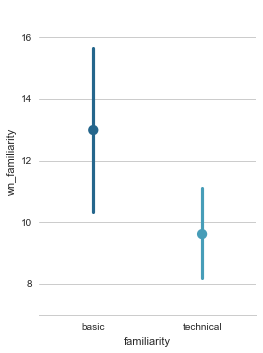

In [17]:
# dont run this before having df active

sns.set(style="whitegrid")
print df_gui4.columns.values
g = sns.factorplot(x="familiarity", y="wn_familiarity", data=df_gui4,
                   palette="YlGnBu_d", size=5, aspect=.75)
g.despine(left=True)

Still decent separation!

### Language models (LSA, LDA and word2vec for wiki corpus tokens and lemmas)

In [44]:
# Load tf-idf representation and dictionary mapping for tokenized corpus
wiki = corpora.MmCorpus('latent_tok_tfidf.mm')
mon_dico = corpora.Dictionary.load_from_text('latent_tok_wordids.txt')

# Lemmatized tf-idf representation and dictionary
wiki_lem = corpora.MmCorpus('latent_lem_tfidf.mm')
mon_dico_lem = corpora.Dictionary.load_from_text('latent_lem_wordids.txt')

print "Tokenized corpus:", wiki
print mon_dico, '\n'
print "Lemmatized corpus:", wiki_lem
print mon_dico_lem

Tokenized corpus: MmCorpus(73898 documents, 29597 features, 6418219 non-zero entries)
Dictionary(29597 unique tokens: [u'fawn', u'schlegel', u'sonja', u'woods', u'spiders']...) 

Lemmatized corpus: MmCorpus(59245 documents, 26640 features, 5275674 non-zero entries)
Dictionary(26640 unique tokens: [u'adjust/VB', u'meteor/NN', u'certificate/NN', u'alcatraz/NN', u'removal/NN']...)


In [45]:
# Load model pickles
# Model training parameters:
#    - LSA and LDA: dictionary = 100,000; topics = 450
#    - Word2vec: dictionary = 100,000; neural layers = 200
    
tok_w2v = models.word2vec.Word2Vec.load("word2vec_tok.model")
lem_w2v = models.word2vec.Word2Vec.load("word2vec_lem.model")
tok_lsi = pickle.load (open ('pickle_lsi.p', 'rb'))
tok_lda = pickle.load (open ('pickle_lda.p', 'rb'))
lem_lsi = pickle.load (open ('pickle_lsi_lem.p', 'rb'))
lem_lda = pickle.load (open ('pickle_lda_lem.p', 'rb'))

## 2. Semantic "sniffing" algorithm

The infoscent method is now applid to the GUI.
The following function takes any state of a GUI, calculates the similarity of each feature in that state with a goal, and returns the features as a list sorted by similarity.


In [49]:
# Needs to know the model type (w2v, w2v_lem, latent, latent_lem)
def sim_sort(state, model, goal, model_type):
    sorted_sims = []
    similaritiz = {}
    goal_v = []
    
    # Word2Vec models
    if (model_type == "w2v") or (model_type == "w2v_lem"):
        
        goal_v = goal.lower().split()
        if model_type == "w2v_lem":
            goal_v = utils.lemmatize(goal)

        for label in state.keys():
            k = label.split()
            if model_type == "w2v_lem":
                k = utils.lemmatize(label)
            sim = model.n_similarity(k, goal_v)
            similaritiz[label]=sim          #adding the similarity scores for any label

    # LSI/LDA models
    elif (model_type == "latent") or (model_type == "latent_lem"):
        
        goal_split = goal.lower().split()
        goal_bow = mon_dico.doc2bow(goal_split)
        if model_type == "latent_lem":
            goal_bow = mon_dico_lem.doc2bow(utils.lemmatize(goal))
        goal_v = model[goal_bow]
        
        ar = []
        for label in state.keys():
            k = label.split()
            if model_type == "latent_lem":
                k = utils.lemmatize(label)
            ar.append(k)

        state2index = [mon_dico.doc2bow(txt) for txt in ar]
        if model_type == "latent_lem":
            state2index = [mon_dico_lem.doc2bow(txt) for txt in ar]
        index = similarities.MatrixSimilarity(model[state2index], num_features=29000)
        indexed_scores = list(index[goal_v])
        
        for index, score in enumerate(indexed_scores):       #this could be replaced by zip()
            label = state.keys()[index]
            similaritiz[label] = score
        
    sorted_sims = sorted(similaritiz.items(), key=operator.itemgetter(1), reverse = True) 
    #print sorted_sims
    return sorted_sims                              #returns a list of tuples i.e [(,), (,)]


# Check output
print sim_sort(gui4, tok_w2v, 'call your parents', 'w2v'), "\n"
print sim_sort(gui4, lem_lsi, 'call your parents', 'latent_lem'), "\n"
print sim_sort(gui4, tok_lsi, 'call your parents', 'latent'), "\n"

[('phone', 0.31809471697231229), ('car', 0.15134431360520267), ('entertainment', 0.057299009097622436)] 

[('car', -0.0083550652), ('entertainment', -0.0085616298), ('phone', -0.078603856)] 

[('phone', 0.2054445), ('entertainment', -0.011600597), ('car', -0.017856039)] 



This function goes recursively down the GUI, comparing semantic similarity of features in each state with the goal description and following the most familiar down the Information Architecture.

In [33]:
def intermediate_sniffer_metrics(gui, model, goal, target_feat, model_type, global_count = 0):
    
    state = sim_sort(gui, model, goal, model_type)    #returned content must be assigned to a variable
    found_goal = False
    #print state
    for label, score in state:
        global_count += 1
        
        if type(gui[label]) is dict:
            found_goal, g_cnt = intermediate_sniffer_metrics(gui[label], model, goal, target_feat, model_type)
            global_count += g_cnt
            if found_goal:
                return True, global_count
    
        elif gui[label] == target_feat:
            return True, global_count

    return False, global_count

intermediate_sniffer_metrics(gui4, tok_w2v, 'cruise control', 'turn off cruise control', 'w2v'), '\n'

((True, 8), '\n')

## 3. Comparison of model performance

For any goal, this function computes the total number of steps required to "find" the correct target feature. Results are stored for every model type.

In [35]:
def auto_test(test_set, model, model_type):
    test_metrics =[]
    goal_l = []
    target_l=[]
    fam = []
    for a, b, c in test_set:
        goal_l.append(a)
        target_l.append(b)
        fam.append(c)
        result = intermediate_sniffer_metrics(gui4, model, b, a , model_type)
        test_metrics.append(result[1])
    return zip(goal_l, target_l,test_metrics, fam, wn_fam, wn_fam_NN)

In [36]:
# testing test_set1 for gui4:

tok_w2v_test = auto_test(test_set1, tok_w2v, 'w2v')
lem_w2v_test = auto_test(test_set1, lem_w2v, 'w2v_lem')
tok_lsi_test = auto_test(test_set1, tok_lsi, 'latent')
tok_lda_test = auto_test(test_set1, tok_lda, 'latent')
lem_lsi_test = auto_test(test_set1, lem_lsi, 'latent_lem')
lem_lda_test = auto_test(test_set1, lem_lda, 'latent_lem')

Create Pandas dataframes for each model.
Prepare columns for visualizations and model comparison, then concatenate all models into a single dataframe.

In [37]:
df_tok_w2v = pd.DataFrame(tok_w2v_test)
df_tok_w2v['model']='word2vec'
df_tok_w2v['prepping']='tokens'

df_lem_w2v = pd.DataFrame(lem_w2v_test)
df_lem_w2v['model']='word2vec'
df_lem_w2v['prepping']='lemmas'

df_tok_lsi = pd.DataFrame(tok_lsi_test)
df_tok_lsi['model']='lsi'
df_tok_lsi['prepping']='tokens'

df_tok_lda = pd.DataFrame(tok_lda_test)
df_tok_lda['model']='lda'
df_tok_lda['prepping']='tokens'

df_lem_lsi = pd.DataFrame(lem_lsi_test)
df_lem_lsi['model']='lsi'
df_lem_lsi['prepping']='lemmas'

df_lem_lda = pd.DataFrame(lem_lda_test)
df_lem_lda['model']='lda'
df_lem_lda['prepping']='lemmas'

frames = [df_tok_w2v, df_lem_w2v, df_tok_lsi, df_tok_lda, df_lem_lsi, df_lem_lda]
df_gui4=pd.concat(frames)
df_gui4.columns = ['target_feat','goal',  'counts','familiarity','wn_familiarity','wn_familiarity_NN','model', 'prepping']

df_gui4.head(5)

,target_feat,goal,counts,familiarity,wn_familiarity,wn_familiarity_NN,model,prepping
0,ventilation settings,change fan speed,4,basic,12.33,12.33,word2vec,tokens
1,increase celsius degrees,increase temperature,3,basic,4.50,4.50,word2vec,tokens
2,recycling mode,prevent exterior air enter,5,technical,7.25,12.00,word2vec,tokens
3,activate cruise control,control my speed,5,technical,14.50,10.00,word2vec,tokens
4,turn off cruise control,disable speed alert,12,technical,6.33,10.00,word2vec,tokens


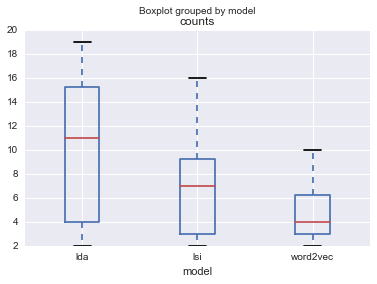

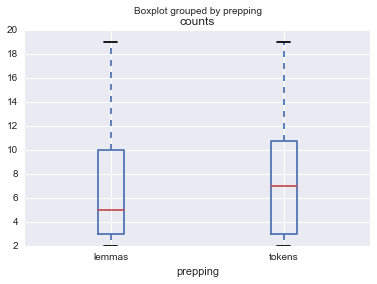

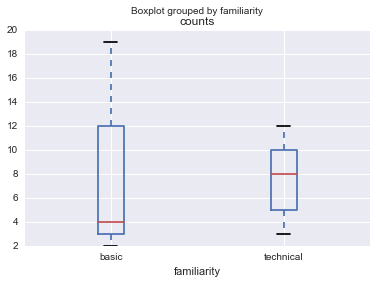

In [38]:
df_gui4.boxplot(column = 'counts', by = 'model')
df_gui4.boxplot(column = 'counts', by = 'prepping')
df_gui4.boxplot(column = 'counts', by = 'familiarity')

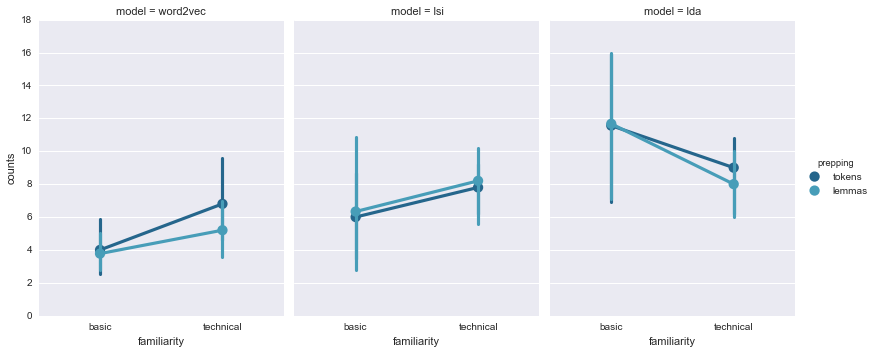

In [274]:
e = sns.factorplot(x="familiarity", y="counts", col = 'model', hue="prepping",data=df_gui4,
                   palette="YlGnBu_d", size=5, aspect=.75)
e.despine(left=True)

In [21]:
print df_gui4.columns

anova_1 = ols('counts ~ C(model, Sum)*C(prepping, Sum)*C(familiarity, Sum)',
               data=df_gui4).fit()
table = sm.stats.anova_lm(anova_1, typ=2) # Type 2 ANOVA DataFrame
print table

Index([u'target_feat', u'goal', u'counts', u'familiarity', u'wn_familiarity',
       u'wn_familiarity_NN', u'model', u'prepping'],
      dtype='object')
                                                         sum_sq  df  \
C(model, Sum)                                        478.166667   2   
C(prepping, Sum)                                       0.011905   1   
C(familiarity, Sum)                                    0.222487   1   
C(model, Sum):C(prepping, Sum)                         5.023810   2   
C(model, Sum):C(familiarity, Sum)                    134.381481   2   
C(prepping, Sum):C(familiarity, Sum)                   1.117725   1   
C(model, Sum):C(prepping, Sum):C(familiarity, Sum)     1.968783   2   
Residual                                            1558.666667  72   

                                                            F    PR(>F)  
C(model, Sum)                                       11.044055  0.000066  
C(prepping, Sum)                                     0.0005

### Similarity matrix for Goals and Target features


In [22]:
goal_index = []
for goal in test_set1:
    goal_index.append(goal[1])

sim_heatmap = pd.DataFrame(index=goal_index)

for i, feat in enumerate(test_set1):
    sim_features = []
    for j, goal in enumerate(test_set1):
        sim_features.append(tok_w2v.n_similarity(feat[0].split(), goal[1].split()) )
    sim_heatmap[feat[0]] = sim_features
sim_heatmap.head()

,ventilation settings,increase celsius degrees,recycling mode,activate cruise control,turn off cruise control,anti theft notification,lane change alert,gps,gaming,play radio,television,contact list,dial,check voice mail messages
change fan speed,0.334732,0.350195,0.318533,0.229320,0.409647,0.239094,0.430893,0.272144,0.247755,0.170977,0.065792,0.280180,0.187660,0.271109
increase temperature,0.451423,0.728940,0.408928,0.248899,0.203634,0.116112,0.406705,0.198475,0.018705,-0.071758,-0.089736,0.156829,0.085851,0.079286
prevent exterior air enter,0.348610,0.230782,0.188675,0.452011,0.545227,0.259917,0.334229,0.207439,0.037684,0.104458,0.019115,0.260333,0.143287,0.359290
control my speed,0.283188,0.210514,0.274728,0.414736,0.619212,0.193429,0.338686,0.249979,0.157924,0.205507,0.066804,0.207102,0.167471,0.324617
disable speed alert,0.425650,0.264661,0.410974,0.449580,0.388973,0.352458,0.566966,0.413387,0.235027,0.089045,-0.032025,0.073983,0.198755,0.378668


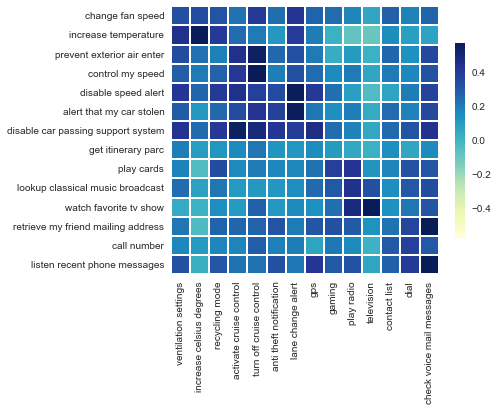

In [23]:
# Plot similarity matrix as heatmap
f, ax = plt.subplots(figsize=(6, 7))

# Draw the heatmap 
sns.heatmap(sim_heatmap,cmap="YlGnBu",
            robust=True,#annot=True,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

## 4. Functionality to format any outline into nested dictionary for full analysis

In [65]:
# translate new outline into nested dico
your_file = ''

def outline2dico (your_file):
    
    guif = open(your_file, "r")

    next_indent=[]
    labels=[]
    temp=0

    for line in guif:
        l_cleaned = line.rstrip()
        r_cleaned = l_cleaned.lstrip()
        labels.append(r_cleaned)

        num_tab = (len(l_cleaned) - len(r_cleaned)) #/3
        prev_tab = num_tab - temp
        temp = num_tab

        next_indent.append(prev_tab)
        short_next_indent = next_indent[1:]

    short_next_indent.append('fin')
    #print short_next_indent, '\n'
    new = zip (labels,short_next_indent)
    #print new

    nested_dico = []
    for n in new:
        if n[1] == 0:
            nested_dico.append('"'+ n[0] + '": "' + n[0] + '"')
        elif n[1] == 1:
            nested_dico.append('"'+ n[0] + '":{')
        elif n[1] == -1:
            nested_dico.append('"'+ n[0] + ': ' + '"'+ n[0] + '"}')
        elif n[1] == -2:
            nested_dico.append('"'+ n[0] + '": ' + '"'+ n[0] + '"}}')

    #print nested_dico, type(nested_dico) 

    s = str(nested_dico)    
    s1=  s.replace("'", '') 
    s2= s1.replace("{,", '{') 
    return s2

# checking things

outline2dico ('gui_toy')

'["food":{ "salad": "salad", "meat: "meat"}, "drink":{ "coffee":{ "orga": "orga", "conventional": "conventional"}}, "misc":{ "call Ej":{ "give present": "give present", "book massage":{ "find groupon": "find groupon", "check agenda": "check agenda"}}]'

In [66]:
###Trying out new gui

guiX = {"food":{"salad": "salad", "meat": "meat"}, 
        "drink":{ "coffee":{ "organic": "organic", "conventional": "conventional"}}, 
        "misc":{ "call friend":{ "give present": "give present", 
                            "book massage":{ "find spa": "find spa", "check agenda": "check agenda"}}}}

recurse_dico_keys(guiX)

test_set_inter = test_set(guiX)

for t in test_set_inter:
    print t

   food
      meat
      salad
   drink
      coffee
         conventional
         organic
   misc
      call friend
         give present
         book massage
            find spa
            check agenda
('meat', '', '', 2)
('salad', '', '', 2)
('conventional', '', '', 3)
('organic', '', '', 3)
('give present', '', '', 3)
('find spa', '', '', 4)
('check agenda', '', '', 4)


In [67]:
test_set2 = [('meat', 'cook chicken', 'basic', '2'),
('salad', 'clean lettuce', 'basic', '2'),
('give present', 'celebrate friend birthday', 'basic', '3'),
('check agenda', 'lookup next availability', 'technical', '4'),
('find spa', 'find beauty salon', 'technical', '4')]

In [71]:
def score_fam_wn (test_set):
    wn_fam = []
    for test in test_set:
        tokenizer = RegexpTokenizer(r'\w+')
        toketxt = tokenizer.tokenize(test[1])
        s = set(stopwords.words('english'))
        filt_wrd = [w for w in toketxt if not w in s]
        w_count = len(filt_wrd)
        g_polys = 0

        for word in filt_wrd:
            w_polys = len(wn.synsets(word))
            g_polys += w_polys

        av_polys = float(g_polys)/float(w_count)
        wn_fam.append(round(av_polys, 2))

    print sorted(wn_fam), '   >> wordnet familiarity' 
    return wn_fam
    
def score_fam_wn_NN (test_set):
    wn_fam_NN = []

    for test in test_set: 
        filt_wrd = []
        g = test[1]
        for w, pos in tag(g): 
            if pos == "NN":
                filt_wrd.append(w)
        #print filt_wrd

        w_count = len(filt_wrd)
        g_polys = 0

        for word in filt_wrd:
            w_polys = len(wn.synsets(word))
            g_polys += w_polys

        av_polys = float(g_polys)/float(w_count)
        wn_fam_NN.append(round(av_polys, 2))

    print sorted(wn_fam_NN), '   >> wordnet familiarity for NN pos only'
    return wn_fam_NN

wn_fam = score_fam_wn (test_set2)
wn_fam_NN = score_fam_wn_NN(test_set2)

[2.0, 3.33, 6.0, 8.0, 17.0]    >> wordnet familiarity
[1.0, 3.0, 3.0, 3.33, 6.0]    >> wordnet familiarity for NN pos only


In [60]:
# Needs to know the model type (w2v, w2v_lem, latent, latent_lem)

def sim_sort(state, model, goal, model_type):
    sorted_sims = []
    similaritiz = {}
    goal_v = []
    
    # Word2Vec models
    if (model_type == "w2v") or (model_type == "w2v_lem"):
        
        goal_v = goal.lower().split()
        if model_type == "w2v_lem":
            goal_v = utils.lemmatize(goal)

        for label in state.keys():
            k = label.split()
            if model_type == "w2v_lem":
                k = utils.lemmatize(label)
            sim = model.n_similarity(k, goal_v)
            similaritiz[label]=sim          #adding the similarity scores for any label

    # LSI/LDA models
    elif (model_type == "latent") or (model_type == "latent_lem"):
        
        goal_split = goal.lower().split()
        goal_bow = mon_dico.doc2bow(goal_split)
        if model_type == "latent_lem":
            goal_bow = mon_dico_lem.doc2bow(utils.lemmatize(goal))
        goal_v = model[goal_bow]
        
        ar = []
        for label in state.keys():
            k = label.split()
            if model_type == "latent_lem":
                k = utils.lemmatize(label)
            ar.append(k)

        state2index = [mon_dico.doc2bow(txt) for txt in ar]
        if model_type == "latent_lem":
            state2index = [mon_dico_lem.doc2bow(txt) for txt in ar]
        index = similarities.MatrixSimilarity(model[state2index], num_features=29000)
        indexed_scores = list(index[goal_v])
        
        for index, score in enumerate(indexed_scores):       #this could be replaced by zip()
            label = state.keys()[index]
            similaritiz[label] = score
        
    sorted_sims = sorted(similaritiz.items(), key=operator.itemgetter(1), reverse = True) 
    #print sorted_sims
    return sorted_sims                              #returns a list of tuples i.e [(,), (,)]


# Check output
print sim_sort(guiX, tok_w2v, 'cook chicken', 'w2v'), "\n"
print sim_sort(guiX, lem_lsi, 'cook chicken', 'latent_lem'), "\n"
print sim_sort(guiX, tok_lsi, 'cook chicken', 'latent'), "\n"

[('food', 0.50357901457607346), ('drink', 0.39989690020306368), ('misc', 0.017622462182509485)] 

[('food', 0.28522587), ('misc', 0.0), ('drink', -0.040114999)] 

[('food', 0.47801524), ('drink', 0.070031837), ('misc', 0.0)] 



In [69]:
def new_intermediate_sniffer_metrics(gui, model, goal, target_feat, model_type, global_count = 0):
    
    state = sim_sort(gui, model, goal, model_type)    #returned content must be assigned to a variable
    found_goal = False
    for label, score in state:
        global_count += 1
        
        if type(gui[label]) is dict:
            found_goal, g_cnt = new_intermediate_sniffer_metrics(gui[label], model, goal, target_feat, model_type)
            global_count += g_cnt
            if found_goal:
                return True, global_count
    
        elif gui[label] == target_feat:
            return True, global_count

    return False, global_count

new_intermediate_sniffer_metrics(guiX, tok_w2v, 'cook chicken', 'meat' ,'w2v'), '\n'

((True, 2), '\n')

In [72]:
def new_auto_test(gui, test_set, model, model_type):
    test_metrics =[]
    goal_l = []
    target_l=[]
    prescrit=[]
    fam = []
    for a, b, c, d in test_set:
        goal_l.append(b)
        target_l.append(a)
        fam.append(c)
        prescrit.append(d)
        result = new_intermediate_sniffer_metrics(gui, model, b, a, model_type)
        test_metrics.append(result[1])
    print test_metrics
    return zip(target_l, goal_l, test_metrics, prescrit, fam, wn_fam, wn_fam_NN)

new_auto_test(guiX, test_set2, tok_w2v, 'w2v')

[2, 3, 10, 5, 11]


[('meat', 'cook chicken', 2, '2', 'basic', 6.0, 6.0),
 ('salad', 'clean lettuce', 3, '2', 'basic', 17.0, 3.0),
 ('give present', 'celebrate friend birthday', 10, '3', 'basic', 3.33, 3.33),
 ('check agenda', 'lookup next availability', 5, '4', 'technical', 2.0, 1.0),
 ('find spa', 'find beauty salon', 11, '4', 'technical', 8.0, 3.0)]

In [73]:
# testing test_set2 for guiX:

xtok_w2v_test = new_auto_test(guiX, test_set2, tok_w2v, 'w2v')
xlem_w2v_test = new_auto_test(guiX, test_set2, lem_w2v, 'w2v_lem')
xtok_lsi_test = new_auto_test(guiX, test_set2, tok_lsi, 'latent')
xtok_lda_test = new_auto_test(guiX, test_set2, tok_lda, 'latent')
xlem_lsi_test = new_auto_test(guiX, test_set2, lem_lsi, 'latent_lem')
xlem_lda_test = new_auto_test(guiX, test_set2, lem_lda, 'latent_lem')

[2, 3, 10, 5, 11]
[2, 2, 10, 4, 11]
[3, 2, 7, 5, 7]
[2, 2, 10, 13, 12]
[2, 2, 10, 7, 10]
[2, 3, 10, 13, 12]


In [74]:
xdf_tok_w2v = pd.DataFrame(xtok_w2v_test)
xdf_tok_w2v['model']='word2vec'
xdf_tok_w2v['prepping']='tokens'

xdf_lem_w2v = pd.DataFrame(xlem_w2v_test)
xdf_lem_w2v['model']='word2vec'
xdf_lem_w2v['prepping']='lemmas'

xdf_tok_lsi = pd.DataFrame(xtok_lsi_test)
xdf_tok_lsi['model']='lsi'
xdf_tok_lsi['prepping']='tokens'

xdf_tok_lda = pd.DataFrame(xtok_lda_test)
xdf_tok_lda['model']='lda'
xdf_tok_lda['prepping']='tokens'

xdf_lem_lsi = pd.DataFrame(xlem_lsi_test)
xdf_lem_lsi['model']='lsi'
xdf_lem_lsi['prepping']='lemmas'

xdf_lem_lda = pd.DataFrame(xlem_lda_test)
xdf_lem_lda['model']='lda'
xdf_lem_lda['prepping']='lemmas'

xframes = [xdf_tok_w2v, xdf_lem_w2v, xdf_tok_lsi, xdf_tok_lda, xdf_lem_lsi, xdf_lem_lda]
df_guiX=pd.concat(xframes)
df_guiX.columns = ['target_feat','goal',  'counts','prescrite','familiarity','wn_familiarity','wn_familiarity_NN','model', 'prepping']

df_guiX.head(5)

,target_feat,goal,counts,prescrite,familiarity,wn_familiarity,wn_familiarity_NN,model,prepping
0,meat,cook chicken,2,2,basic,6.00,6.00,word2vec,tokens
1,salad,clean lettuce,3,2,basic,17.00,3.00,word2vec,tokens
2,give present,celebrate friend birthday,10,3,basic,3.33,3.33,word2vec,tokens
3,check agenda,lookup next availability,5,4,technical,2.00,1.00,word2vec,tokens
4,find spa,find beauty salon,11,4,technical,8.00,3.00,word2vec,tokens


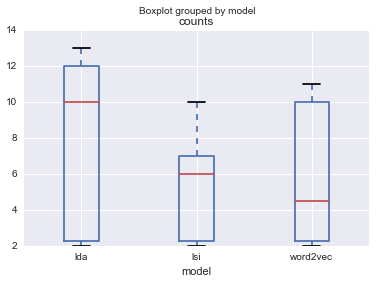

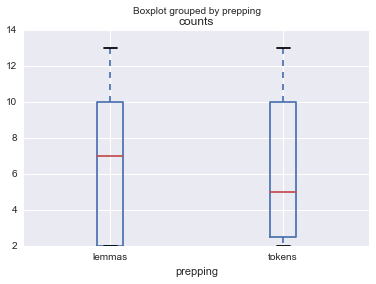

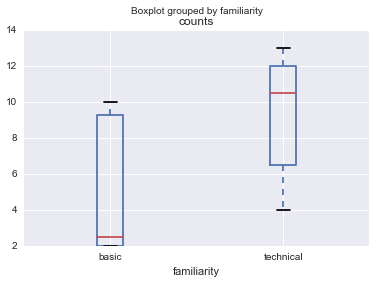

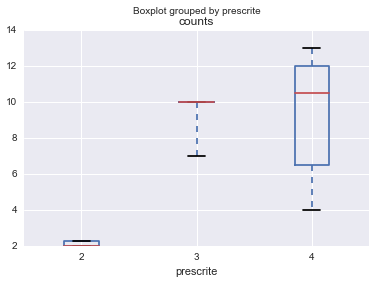

In [83]:
df_guiX.boxplot(column = 'counts', by = 'model')
df_guiX.boxplot(column = 'counts', by = 'prepping')
df_guiX.boxplot(column = 'counts', by = 'familiarity')
df_guiX.boxplot(column = 'counts', by = 'prescrite')

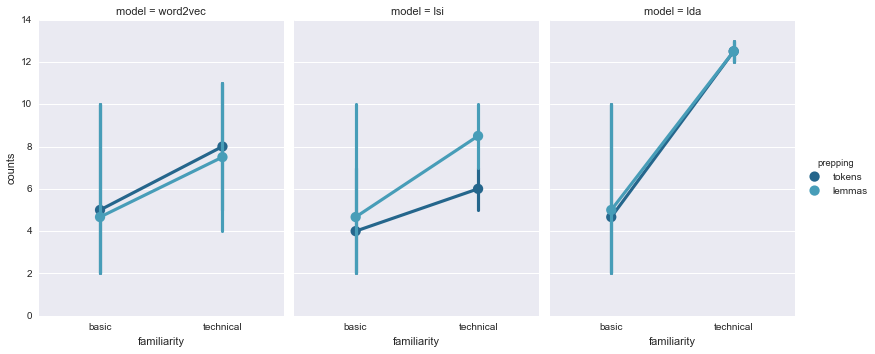

In [75]:
e = sns.factorplot(x="familiarity", y="counts", col = 'model', hue="prepping",data=df_guiX,
                   palette="YlGnBu_d", size=5, aspect=.75)
e.despine(left=True)

## 5. Analysis flow

In [18]:
outline2dico('gui_5')

'["home":{ "car":{ "air conditioning":{ "ventilation settings": "ventilation settings", "saccadic": "saccadic", "continious: "continious"}, "filter settings":{ "recycle interior air": "recycle interior air", "charcoal mode": "charcoal mode", "pollen mode: "pollen mode"}, "temperature settings":{ "display current temperature": "display current temperature", "hotter": "hotter", "colder: "colder"}, "driving assistance":{ "cruise control":{ "activate": "activate", "turn off: "turn off"}, "anti theft protection":{ "choose notification recipient": "choose notification recipient", "phone paring for tracking": "phone paring for tracking", "distant vehicle deactivation: "distant vehicle deactivation"}, "lane change alert":{ "vibrate steering wheel": "vibrate steering wheel", "vibrate pedal": "vibrate pedal", "vibrate rearview mirrors: "vibrate rearview mirrors"}, "gps":{ "check current coordinates": "check current coordinates", "enter destination": "enter destination", "recent destination": "re

In [5]:
gui5 = {"car":{ "air conditioning":{ "ventilation settings": "ventilation settings","pulse": "pulse", "continuous": "continuous"}, 
                                    "filter settings":{ "recycle interior air": "recycle interior air", "charcoal mode": "charcoal mode", "pollen mode": "pollen mode"}, 
                                    "temperature settings":{ "display current temperature": "display current temperature", "hotter": "hotter", "colder": "colder"}}, 
                "driving assistance":{ "cruise control":{ "activate": "activate", "turn off": "turn off"}, 
                                        "anti theft protection":{ "choose notification recipient": "choose notification recipient", 
                                        "phone pairing tracking": "phone pairing tracking", "stop vehicle": "stop vehicle"},
                                        "lane change alert":{ "vibrate steering wheel": "vibrate steering wheel", "vibrate pedal": "vibrate pedal", "vibrate rear view mirrors": "vibrate rear view mirrors"},
                                        "gps":{ "check current coordinates": "check current coordinates", "enter destination": "enter destination", "recent destination": "recent destination"}},
                "entertainment":{ "gaming":{ "poker": "poker", "chess": "chess", "online apps": "online apps"},
                                 "television":{ "documentaries": "documentaries", "movies sorted":{ "genre": "genre", "rating": "rating", "release date": "release date"}, 
                                                                "tv series": "tv series"},
                                                                "radio":{ "classic": "classic", "pop": "pop", "electronic": "electronic"}},
                        "phone":{ "contact lists":{ "family": "family", "work": "work", "emergency": "emergency"}, "dial": "dial", "voice mail":{ "listen messages": "listen messages", 
                                                                    "erase last message": "erase last message", "change greetings": "change greetings"}, "pay bills": "pay bills"}}

***D3 representation (nested2d3(gui5)):***

<img src="files/D3_gui5.png" width=900 />


In [79]:
###Trying out new gui

recurse_dico_keys(gui5)

test_set_inter = test_set(gui5)

for t in test_set_inter:
    print t

   car
      air conditioning
         ventilation settings
         saccadic
         continious
      filter settings
         recycle interior air
         pollen mode
         charcoal mode
      temperature settings
         display current temperature
         colder
         hotter
   driving assistance
      cruise control
         activate
         turn off
      anti theft protection
         phone paring for tracking
         distant vehicle deactivation
         choose notification recipient
      lane change alert
         vibrate pedal
         vibrate rearview mirrors
         vibrate steering wheel
      gps
         recent destination
         enter destination
         check current coordinates
   phone
      pay bills
      contact lists
         work
         emergency
         family
      dial
      voice mail
         change greetings
         listen messages
         erase last message
   entertainment
      gaming
         online apps
         poker
         ch

In [132]:
test_set3 = [
('hotter', 'increase temperature', 'basic', 3),
('pollen mode', 'set ventilation against allergies', 'technical', 3),
('choose notification recipient', 'call police if car stolen', 'technical', 3),
('pay bills', 'phone plan', 'basic', 2),
('change greetings', 'record new greeting message', 'basic', 3),
('chess', 'invite friend play chess', 'technical', 3),
('rating', 'list best movies', 'technical', 4),
('release date', 'list most recent movies', 'basic', 4),
('classic', 'mozart playlist', 'basic', 3)]

In [133]:
wn_fam = score_fam_wn (test_set3)
wn_fam_NN = score_fam_wn_NN(test_set3)

[1.5, 3.67, 4.5, 5.5, 8.75, 12.75, 16.67, 17.0, 17.0]    >> wordnet familiarity
[1.0, 4.5, 5.0, 5.5, 7.0, 7.0, 19.67, 23.0, 24.5]    >> wordnet familiarity for NN pos only


In [134]:
print sim_sort(gui5, tok_w2v, 'call parents', 'w2v'), "\n"
print sim_sort(gui5, lem_lsi, 'call parents', 'latent_lem'), "\n"
print sim_sort(gui5, tok_lsi, 'call parents', 'latent'), "\n"

[('phone', 0.23648433162637389), ('driving assistance', 0.22552974909688811), ('car', 0.15201573767600157), ('entertainment', -0.015887073376660087)] 

[('phone', 0.19294831), ('driving assistance', 0.053816766), ('car', 0.0087312944), ('entertainment', -0.00058004539)] 

[('phone', 0.28467852), ('driving assistance', 0.052090496), ('car', -0.0022740178), ('entertainment', -0.035725854)] 



In [135]:
new_intermediate_sniffer_metrics(gui5, tok_w2v, 'call parents', 'dial' ,'w2v'), '\n'

((True, 2), '\n')

In [136]:
ytok_w2v_test = new_auto_test(gui5, test_set3, tok_w2v, 'w2v')
ylem_w2v_test = new_auto_test(gui5, test_set3, lem_w2v, 'w2v_lem')
ytok_lsi_test = new_auto_test(gui5, test_set3, tok_lsi, 'latent')
ytok_lda_test = new_auto_test(gui5, test_set3, tok_lda, 'latent')
ylem_lsi_test = new_auto_test(gui5, test_set3, lem_lsi, 'latent_lem')
ylem_lda_test = new_auto_test(gui5, test_set3, lem_lda, 'latent_lem')

[21, 36, 17, 7, 5, 30, 6, 4, 21]
[21, 39, 18, 11, 4, 3, 5, 4, 16]
[35, 7, 17, 3, 38, 38, 6, 5, 54]
[3, 8, 36, 2, 50, 16, 22, 23, 29]
[31, 3, 18, 7, 6, 54, 12, 26, 45]
[3, 8, 33, 2, 55, 16, 20, 25, 29]


In [137]:
ydf_tok_w2v = pd.DataFrame(ytok_w2v_test)
ydf_tok_w2v['model']='word2vec'
ydf_tok_w2v['prepping']='tokens'

ydf_lem_w2v = pd.DataFrame(ylem_w2v_test)
ydf_lem_w2v['model']='word2vec'
ydf_lem_w2v['prepping']='lemmas'

ydf_tok_lsi = pd.DataFrame(ytok_lsi_test)
ydf_tok_lsi['model']='lsi'
ydf_tok_lsi['prepping']='tokens'

ydf_tok_lda = pd.DataFrame(ytok_lda_test)
ydf_tok_lda['model']='lda'
ydf_tok_lda['prepping']='tokens'

ydf_lem_lsi = pd.DataFrame(ylem_lsi_test)
ydf_lem_lsi['model']='lsi'
ydf_lem_lsi['prepping']='lemmas'

ydf_lem_lda = pd.DataFrame(ylem_lda_test)
ydf_lem_lda['model']='lda'
ydf_lem_lda['prepping']='lemmas'

yframes = [ydf_tok_w2v, ydf_lem_w2v, ydf_tok_lsi, ydf_tok_lda, ydf_lem_lsi, ydf_lem_lda]
df_gui5=pd.concat(yframes)
df_gui5.columns = ['target_feat','goal',  'counts','prescrite','familiarity','wn_familiarity','wn_familiarity_NN','model', 'prepping']

df_gui5.head(5)

,target_feat,goal,counts,prescrite,familiarity,wn_familiarity,wn_familiarity_NN,model,prepping
0,hotter,increase temperature,21,3,basic,4.50,4.5,word2vec,tokens
1,pollen mode,set ventilation against allergies,36,3,technical,16.67,24.5,word2vec,tokens
2,choose notification recipient,call police if car stolen,17,3,technical,12.75,23.0,word2vec,tokens
3,pay bills,phone plan,7,2,basic,5.50,5.5,word2vec,tokens
4,change greetings,record new greeting message,5,3,basic,8.75,5.0,word2vec,tokens


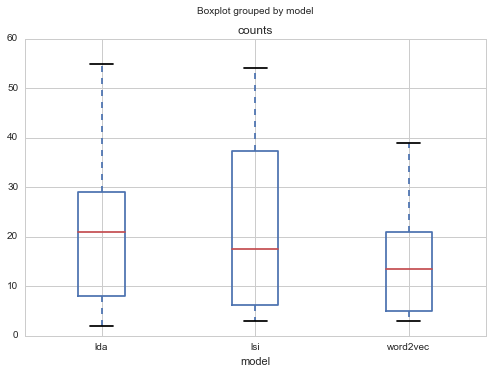

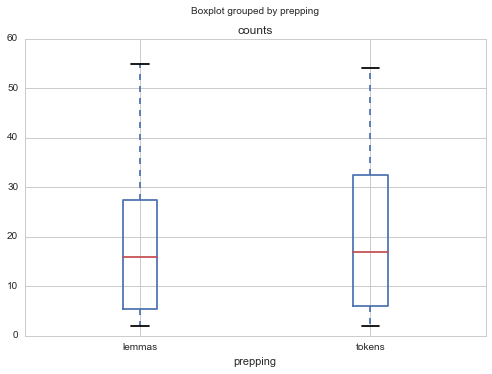

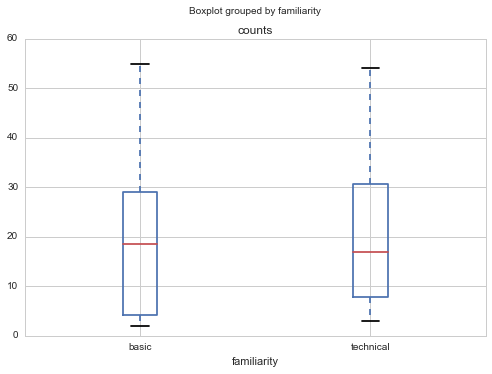

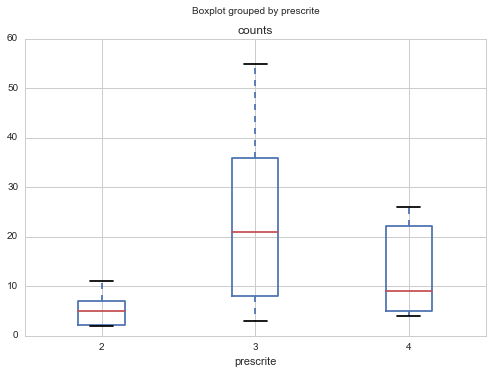

In [138]:
df_gui5.boxplot(column = 'counts', by = 'model')
df_gui5.boxplot(column = 'counts', by = 'prepping')
df_gui5.boxplot(column = 'counts', by = 'familiarity')
df_gui5.boxplot(column = 'counts', by = 'prescrite')

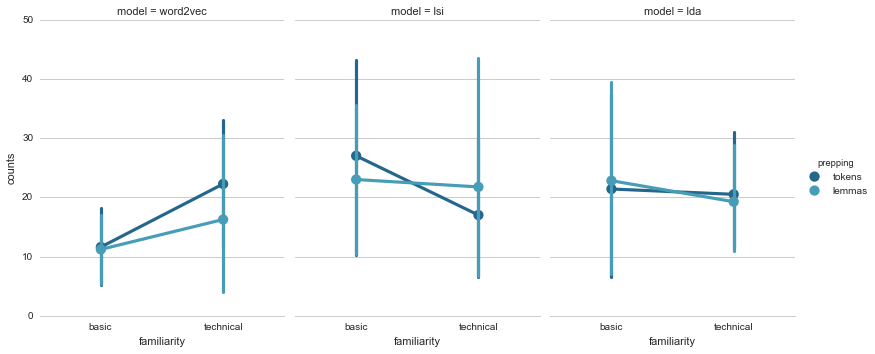

In [139]:
e = sns.factorplot(x="familiarity", y="counts", col = 'model', hue="prepping",data=df_gui5,
                   palette="YlGnBu_d", size=5, aspect=.75)
e.despine(left=True)

## Next steps

- test for normality, if negative revert to non-parametric test 
- tweak model parameters
- compute similarity scores for entire path
- ...